In [1]:
%matplotlib inline
import pylab as pl
pl.style.use('dark_background')
pl.rcParams['figure.figsize'] = (12,10)

# Observation Planning

Questions to ask when planning a photometric observing session ("run"):

1. __Where is my target?__
2. __When can I observe my target?__
3. __How do I know when I've found my target (make a finder chart)?__
3. How long do I need to observe?
4. How will I calibrate my data?

## Where is my target? 

Let's pick a few exciting targets to look at.  These are gigantic evolved stars, Luminous Blue Variables and Yellow Hypergiants and Supergiants:

1. P Cygni
2. Rho Cassiopeia
3. HD 168607
4. Polaris

To find where these sources are on the sky, we can query a few databases, including the SESAME name resolver service (http://cds.u-strasbg.fr/cgi-bin/Sesame) and the SIMBAD service.  We can do this using `astropy`, the main library for astronomical analysis.


In [2]:
from astropy import coordinates, units

In [3]:
pcyg_coord = coordinates.SkyCoord.from_name('P Cygni')
pcyg_coord

<SkyCoord (ICRS): (ra, dec) in deg
    (304.44667535, 38.03293131)>

We can display this in other ways too:

In [4]:
pcyg_coord.to_string('hmsdms')

'20h17m47.2021s +38d01m58.5527s'

The SIMBAD service gives us a little additional information:

In [5]:
from astroquery.simbad import Simbad

In [6]:
pcyg_simbad = Simbad.query_object('P Cygni')
pcyg_simbad

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object
* P Cyg,20 17 47.2020,+38 01 58.552,11,11,0.120,0.130,90,A,O,2007A&A...474..653V


We'll just use SESAME for the others, though.  Fill in the SESAME approach for `rhocas` (Rho Cassiopeia), `hd168607` (HD 168607), and `polaris` ("Polaris"):

In [7]:
# student answer here
rhocas_coord = coordinates.SkyCoord.from_name('Rho Cassiopeia')
hd168607_coord = coordinates.SkyCoord.from_name('HD 168607')
polaris_coord = coordinates.SkyCoord.from_name('Polaris')

In [8]:
print(pcyg_coord.to_string('hmsdms'))
print(rhocas_coord.to_string('hmsdms'))
print(hd168607_coord.to_string('hmsdms'))
print(polaris_coord.to_string('hmsdms'))

20h17m47.2021s +38d01m58.5527s
23h54m23.034s +57d29m57.7669s
18h21m14.8855s -16d22m31.7605s
02h31m49.0946s +89d15m50.7923s


## When can I observe my target?

Next, knowing where these are on the sky, we can ask what times of year they are up at night.

We first have to define where _we_ are by setting the observatory location.

In [9]:
from astroplan import Observer
from astropy import units as u # shortcut

In [10]:
# sometimes we have to update the database; if that's necessary, a message will pop up telling us
from astroplan import download_IERS_A
download_IERS_A()

In [11]:
CTO = Observer(location=coordinates.EarthLocation(lat=29.643018, lon=-82.349004*u.deg, height=31*u.m),
               timezone='EST',
               name='University of Florida Campus Teaching Observatory',
              )
CTO

<Observer: name='University of Florida Campus Teaching Observatory',
    location (lon, lat, el)=(-82.349004 deg, 29.643018 deg, 30.99999999950558 m),
    timezone=<StaticTzInfo 'EST'>>

Before we go on, we can use some information we already have in hand to determine approximately when we can observe these objects.  It is important to do this sort of qualitative 'sanity check' to ensure that the numbers coming from the computer are reasonable.

The March equinox defines the zero-point of the Right Ascension coordinate, which means that 12h RA goes overhead at midnight.

There are 24 hours in a day and 12 months in a year.  By how many hours does the sky rotate each month?

A: 2h

How many degrees?

A: 30 deg

Given the above information, answer the following questions:

1. What is the Right Ascension of the Sun in the March (vernal) equinox?

A: 0h

2. What is the RA of the Sun at the September (autumnal) equinox?

A: 12h

3. During what season or month do our targets reach zenith at midnight? (one answer per target)

A:
* P Cyg: Summer (late May)
* Rho Cas: Fall (August)
* HD 168607: Summery (July / Summer Solstice)
* Polaris: Always up

Having done these checks, we can proceed to get more precise answers.

We create `target` objects to observe at different times.

In [12]:
from astroplan import FixedTarget

In [13]:
pcyg_target = FixedTarget(pcyg_coord, name="P Cygni")
rhocas_target = FixedTarget(rhocas_coord, name="Rho Cas")
hd168607_target = FixedTarget(hd168607_coord, name="HD 168607")
polaris_target = FixedTarget(polaris_coord, name="Polaris")
pcyg_target, rhocas_target, hd168607_target, polaris_target

(<FixedTarget "P Cygni" at SkyCoord (ICRS): (ra, dec) in deg (304.44667535, 38.03293131)>,
 <FixedTarget "Rho Cas" at SkyCoord (ICRS): (ra, dec) in deg (358.59597498, 57.4993797)>,
 <FixedTarget "HD 168607" at SkyCoord (ICRS): (ra, dec) in deg (275.31202306, -16.37548903)>,
 <FixedTarget "Polaris" at SkyCoord (ICRS): (ra, dec) in deg (37.95456067, 89.26410897)>)

To determine the observability of an object, we ask whether the object is "up" (in the sky, as opposed to underfoot), and whether it is night time.

What time are you working on this notebook?  Is it night?  Are the target sources "up"?  (answer these before filling out the code)

Since the answers to all of our questions depend on both the time of day and the time of year, we need to define our time.

In [14]:
from astropy.time import Time

In [15]:
now = Time.now()
now

<Time object: scale='utc' format='datetime' value=2021-01-19 22:54:55.739248>

Are any of these sources "up"?

In [16]:
CTO.target_is_up(now, [pcyg_target, rhocas_target, hd168607_target, polaris_target])

array([ True,  True, False,  True])

At least some are "up" at the time of writing.

OK, but is it night?

In [17]:
CTO.is_night(now)

True

For planning purposes, we care more about what the future holds and how we're going to schedule our time, so we want to know when sunrise and sunset are.  We use `now` to tell the software that we care about sunrise and sunset _today_; we can put in future days to find out how sunrise/sunset times change.

In [18]:
CTO.sun_set_time(now), CTO.sun_rise_time(now)

(<Time object: scale='utc' format='jd' value=2459234.4528833716>,
 <Time object: scale='utc' format='jd' value=2459234.0198751357>)

These aren't formatted in a very familiar way, so we can use a standard format - e.g., ISO, the International Standards Organization format - to show them more nicely:

In [19]:
CTO.sun_set_time(now).iso, CTO.sun_rise_time(now).iso

('2021-01-19 22:52:09.123', '2021-01-19 12:28:37.212')

Those times look a bit funny because they're in UTC, Universal Coordinated Time.

Time zones are tricky, so we rely on libraries to help us with them.

In [20]:
now.to_datetime(timezone=CTO.timezone).isoformat()

'2021-01-19T17:54:55.739248-05:00'

That's a pretty verbose way to ask for and display this, so we can define a shortcut to get the time of day in the Eastern time zone:

In [21]:
def eastern(time):
    est = time.to_datetime(timezone=CTO.timezone)
    
    return est.strftime('%H:%M:%S')

In [22]:
(eastern(CTO.sun_set_time(now)), eastern(CTO.sun_rise_time(now)))

('17:52:09', '07:28:37')

Now you can see that sunset is around 5:30 PM and sunrise is around 7:30 AM.  Note that we have set first, rise second, because we care about the interval between the sun going down and coming back up again, not the daytime.

We need to know the sun's rise and set time to avoid it, but we also can ask when our sources rise and set.

In [23]:
(eastern(CTO.target_rise_time(time=now, target=pcyg_target)),
 eastern(CTO.target_set_time(time=now, target=pcyg_target)))

('05:01:54', '20:35:18')

In [24]:
(eastern(CTO.target_rise_time(time=now, target=rhocas_target)),
 eastern(CTO.target_set_time(time=now, target=rhocas_target)))

('06:13:11', '02:40:31')

In [25]:
(eastern(CTO.target_rise_time(time=now, target=hd168607_target)),
 eastern(CTO.target_set_time(time=now, target=hd168607_target)))

('05:30:12', '16:15:25')

In [26]:
### Note: this will fail!  "Comment it out" and move on if it crashes, or ignore it if it gives you a warning
((CTO.target_rise_time(time=now, target=polaris_target)),
 (CTO.target_set_time(time=now, target=polaris_target)))

/home/adam/anaconda3/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)


(<Time object: scale='utc' format='jd' value=nan>,
 <Time object: scale='utc' format='jd' value=nan>)

What's going on with that last one?  Since Polaris is the North Star, it is always observable from any northern observatory.  It has no rise and set time!

We can visualize the "up time" for the targets using an _airmass plot_, which plots the airmass versus time of night.

[Airmass](https://en.wikipedia.org/wiki/Air_mass_(astronomy)) is the path length of air through which we're observing, and it is usually approximated as secant(zenith angle) and measured relative to zenith.


1 airmass is straight up, and is the minimum amount of atmosphere through which you can observe.

Generally, it is best to observe at airmass < 2 when possible.  Airmass up to ~3 can be useful.  Beyond that, serious complications tend to arise.

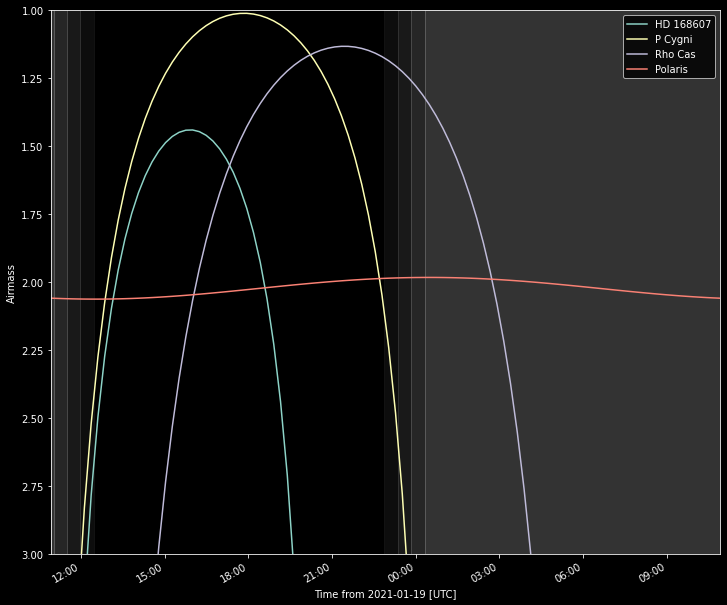

In [27]:
from astroplan.plots import plot_airmass 
import matplotlib.pyplot as plt 

plot_airmass([hd168607_target, pcyg_target, rhocas_target, polaris_target],
             observer=CTO,
             time=now,
             brightness_shading=True)

plt.legend(loc='best')
plt.show() 

Note that the X-axis is in Universal Coordinated Time (UTC).  If you want the plots in local time, you can request that the local timezone be used (but only for certain versions of astroplan):

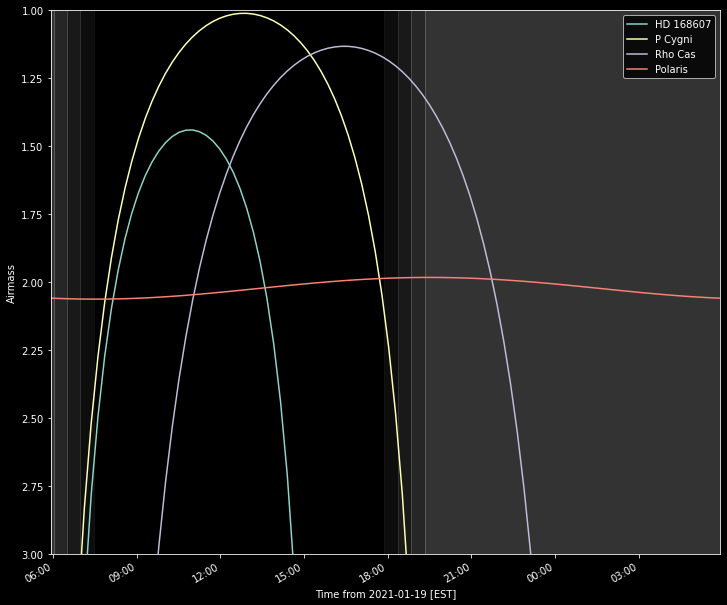

In [28]:
# if this fails, comment it out and continue
plot_airmass([hd168607_target, pcyg_target, rhocas_target, polaris_target],
             observer=CTO,
             time=now.to_datetime(timezone=CTO.timezone),
             use_local_tz=True,
             brightness_shading=True)

plt.legend(loc='best')
plt.show() 

Answer some questions:

Which sources are up at night?  For how long is each source observable at airmass $\lesssim2$?  (Polaris is close enough)

Rho Cas is up at night for about 3h.  Polaris is up all night.  The rest are down.

## How do I know when I've found my target? Make a finder chart

We need to know how to tell we're 'on target' when we've pointed our telescope at the right part of the sky.  With binoculars and other very wide field-of-view instruments, we can use known asterisms or constellations to navigate by, but with narrow field-of-view professional telescopes, we have to use fainter stars to aid our pointing.

We can obtain finder charts from the many public astronomical archives, like the Digitized Sky Survey, which carefully logged the whole sky in visible light images.

`astroplan` provides a means to obtain these images and plot them.  It uses `astroquery`, another library, to query the `SkyView` image cutout service.

In [29]:
from astroplan.plots import plot_finder_image

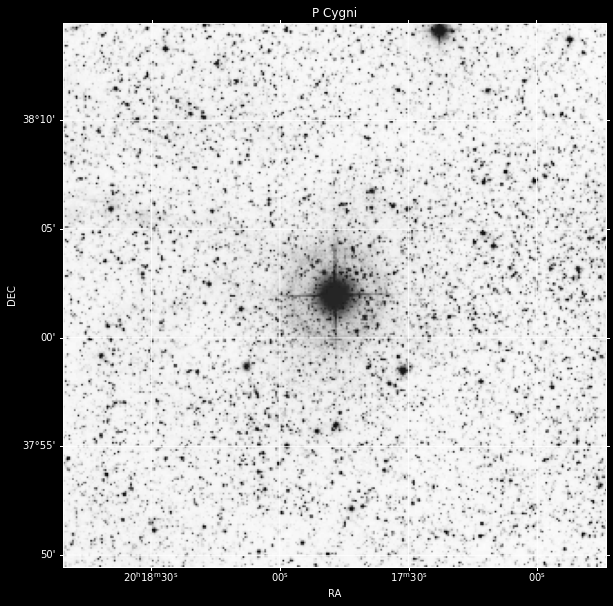

In [30]:
ax, hdu = plot_finder_image(pcyg_target, survey='DSS', fov_radius=25*u.arcmin)

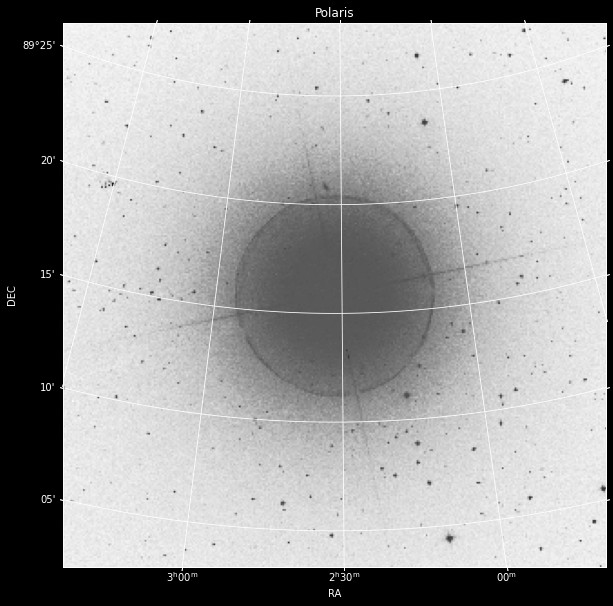

In [31]:
ax, hdu = plot_finder_image(polaris_target, survey='DSS', fov_radius=25*u.arcmin)

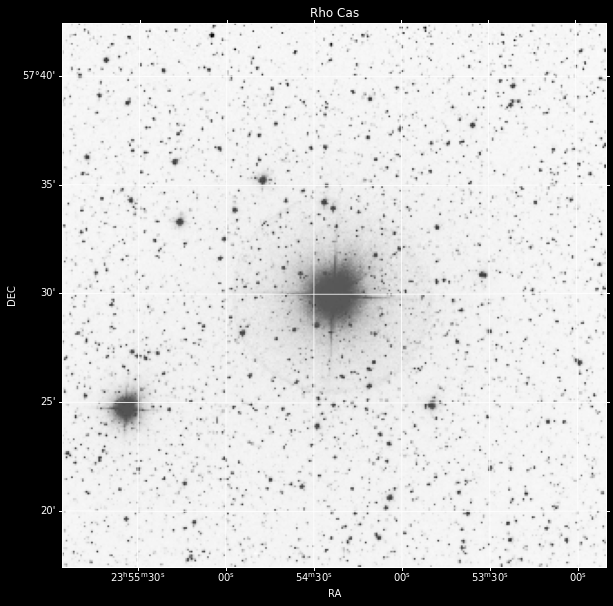

In [32]:
ax, hdu = plot_finder_image(rhocas_target, survey='DSS', fov_radius=25*u.arcmin)

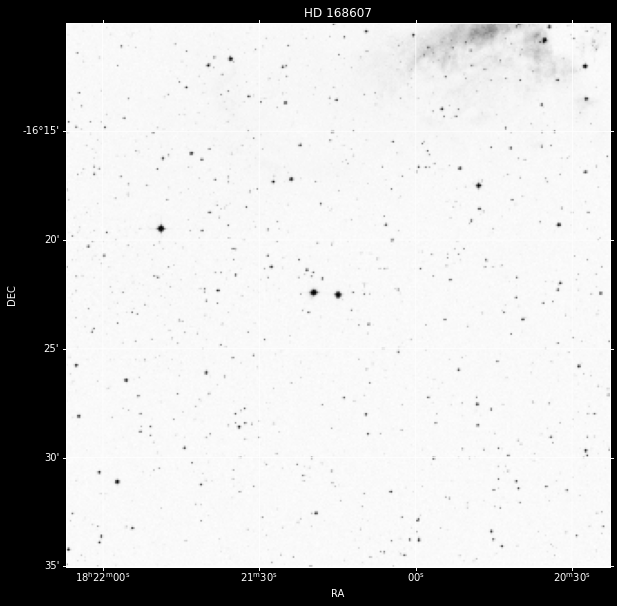

In [33]:
ax, hdu = plot_finder_image(hd168607_target, survey='DSS', fov_radius=25*u.arcmin)

You might notice these images come out a little smaller than you would like.  You can control the figure size using matplotlib commands:

In [34]:
import matplotlib.pyplot as plt

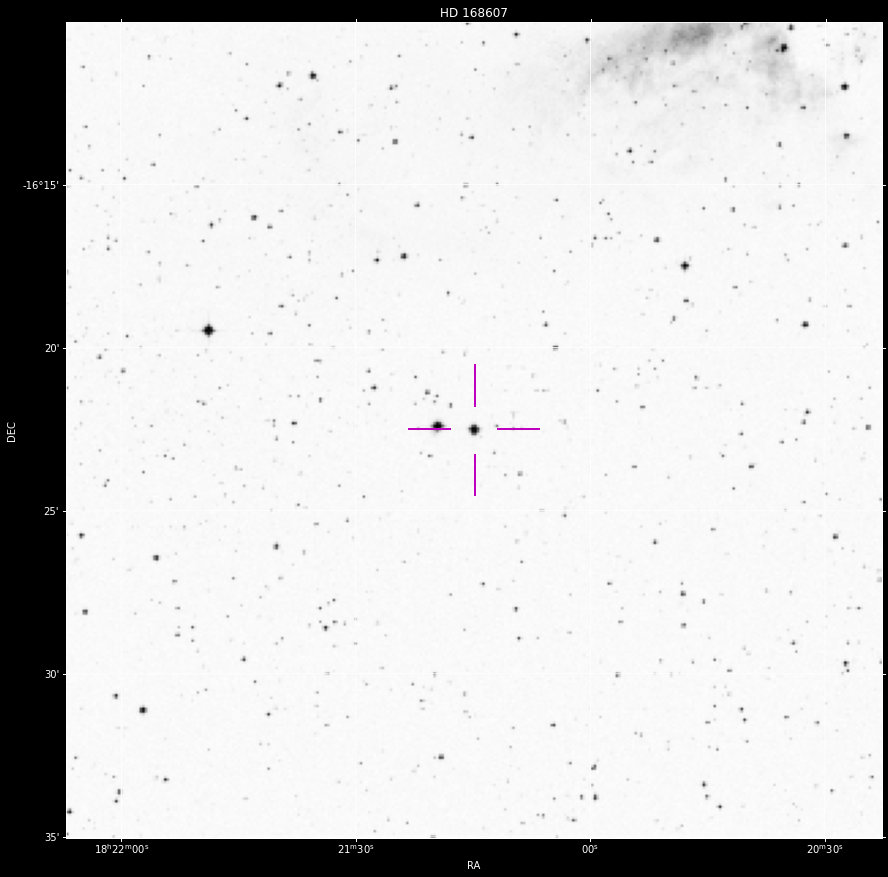

In [35]:
# specify the figure size in inches
plt.figure(figsize=(15, 15))
# a "reticle" is a set of crosshairs highlighting the target source
ax, hdu = plot_finder_image(hd168607_target, survey='DSS', fov_radius=25*u.arcmin, reticle=True)

In [36]:
# use the ? functionality to look at the docstring (documentation text) of a function
plot_finder_image?

Often, we want to adjust the finder chart so that it only shows stars we're likely to see.

Especially when you're using your eyes, which are not very sensitive compared to CCDs, you should limit the finder chart to bright stars.

In the code below, we do this by setting `vmin`, the _lowest_ value we display, to a high number.  That turns all of the faint stars white in the image, blending them into the background.

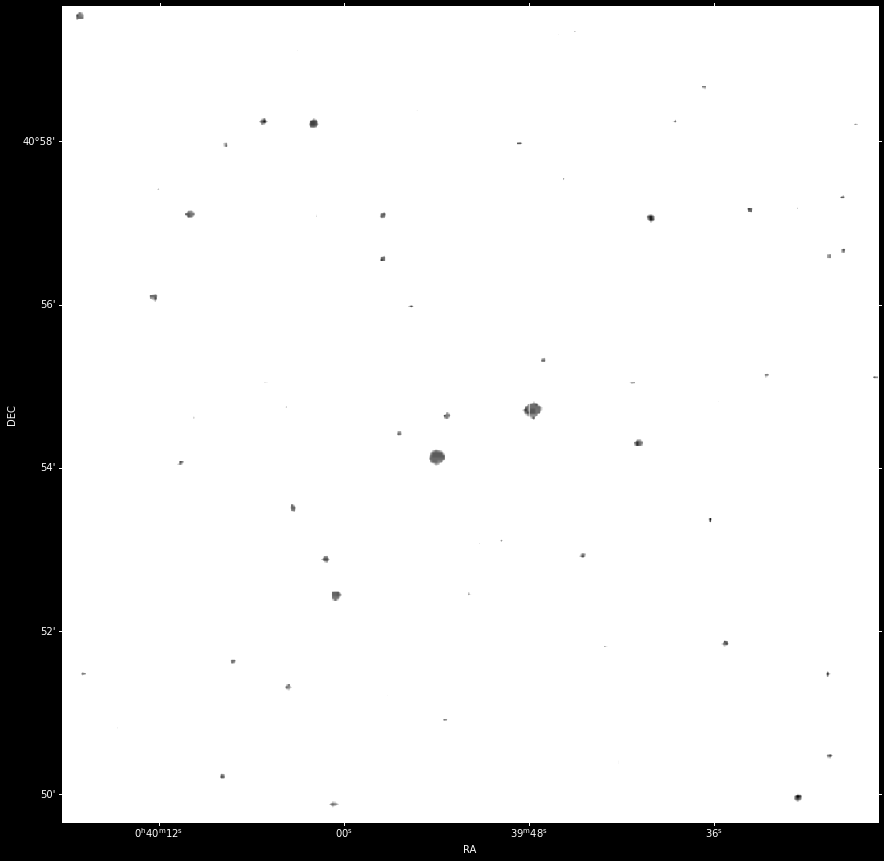

In [37]:
plt.figure(figsize=(15, 15))
ax, hdu = plot_finder_image(coordinates.SkyCoord(9.966, 40.911, frame='fk5',
                                                 unit=(u.deg, u.deg)), survey='DSS',
                            fov_radius=10*u.arcmin, reticle=False, style_kwargs={'vmin': 12000})

Why did we choose 12000?  That was based on this plot of the _histogram_ of the image, showing how many pixels there are per brightness bin.  As you can see, we only included a tiny fraction of the brightest pixels.

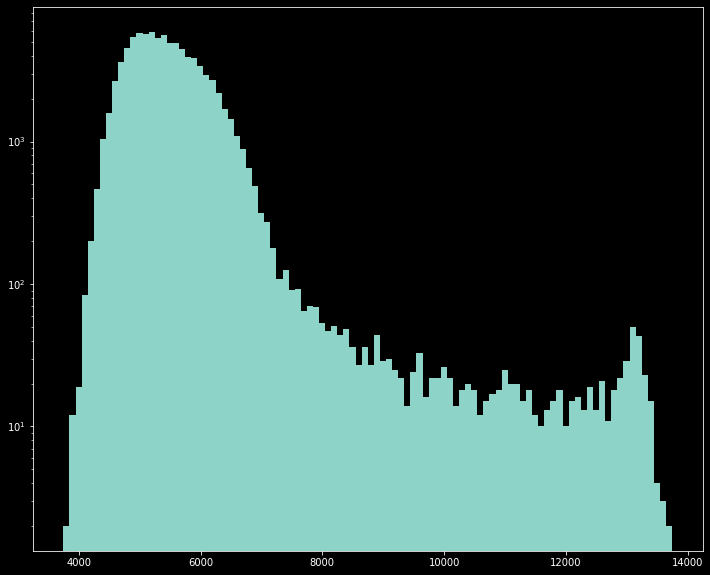

In [38]:
_ = plt.hist(hdu.data.ravel(), bins=100, log=True)

## Planning for Clouds

What if the night is cloudy?  For professional observations, we will often write off cloudy nights as a lost cause, but for this class, sometimes we need to find the holes in the clouds and observe whatever's there! 

We can enable this by making sky charts.

In [39]:
from astroplan.plots import plot_sky
import astroplan

<PolarAxesSubplot:>

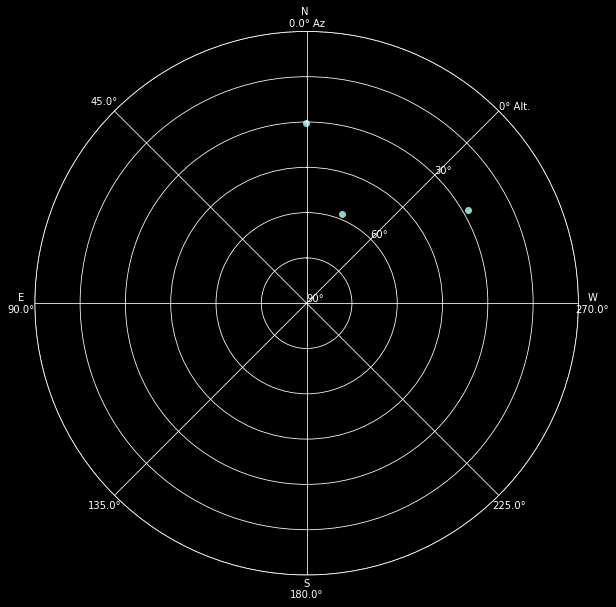

In [40]:
# first, let's find out where the objects are at sunset
sunset = CTO.sun_set_time(now)

# then, set up a list of our targets
targets = [hd168607_target, pcyg_target, rhocas_target, polaris_target,]

# then plot where they all are
plot_sky(target=targets, observer=CTO, time=sunset)

In [41]:
# then, let's look 1 hour after sunset
onehour_after_sunset = sunset + 1*u.hour
twohours_after_sunset = sunset + 2*u.hour

63d40m40.19s
60d20m47.5996s
51d50m17.0537s


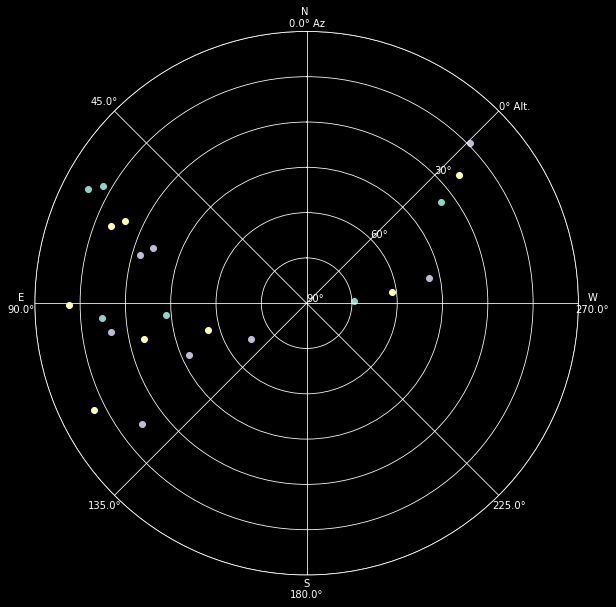

In [53]:
# we'll plot the targets at three different times, plus the Moon's location as a black circle
plot_sky(target=targets, observer=CTO, time=sunset)
plot_sky(target=targets, observer=CTO, time=onehour_after_sunset)
plot_sky(target=targets, observer=CTO, time=twohours_after_sunset)
for time in [sunset, onehour_after_sunset, twohours_after_sunset]:
    moon = astroplan.moon.get_moon(time, location=CTO.location)
    print(CTO.altaz(time=time, target=moon).alt)
    plot_sky(target=moon,
             observer=CTO, time=time, style_kwargs={'marker':'o', 'color': 'k'})

# EXERCISE

Create an altitude plot (showing the 'up time'), a sky plot, and a finder chart for each of the following sources:
1. M33
2. NGC 869
3. Gamma Andromedae

In [43]:
m33 = FixedTarget(coordinates.SkyCoord.from_name('M33'), name='M33')
ngc869 = FixedTarget(coordinates.SkyCoord.from_name('NGC 869'), name='NGC 869')
gamand = FixedTarget(coordinates.SkyCoord.from_name('Gamma Andromedae'), name='$\gamma$ Andromedae')

In [44]:
m33.coord.to_string('hmsdms'), ngc869.coord.to_string('hmsdms'), gamand.coord.to_string('hmsdms')

('01h33m50.904s +30d39m35.79s',
 '02h19m00s +57d07m42s',
 '02h03m53.9523s +42d19m47.0223s')

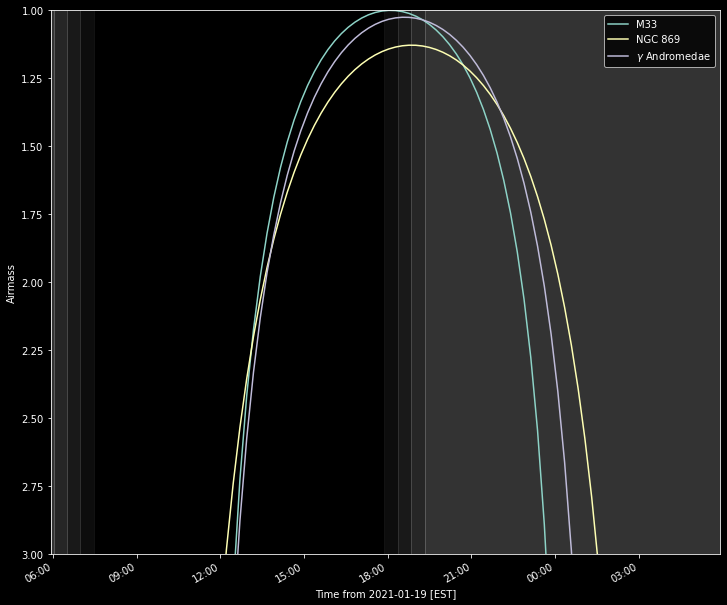

In [45]:
plot_airmass([m33, ngc869, gamand],
             observer=CTO,
             time=now.to_datetime(timezone=CTO.timezone),
             use_local_tz=True,
             brightness_shading=True)

plt.legend(loc='best')
plt.show() 

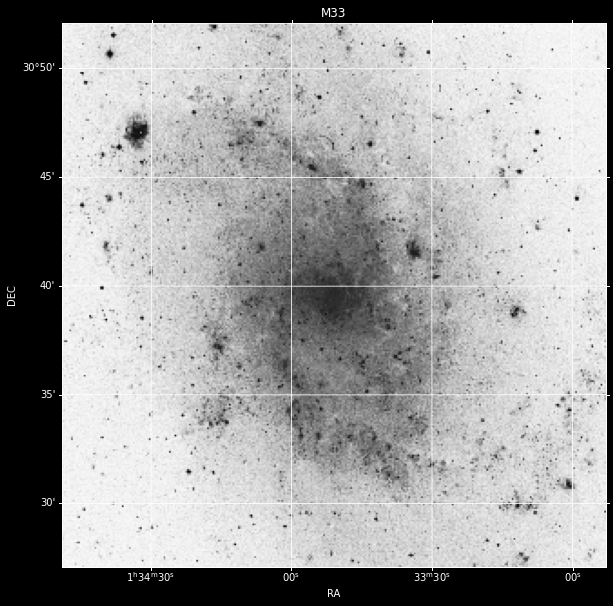

In [46]:
ax, hdu = plot_finder_image(m33, survey='DSS', fov_radius=25*u.arcmin)

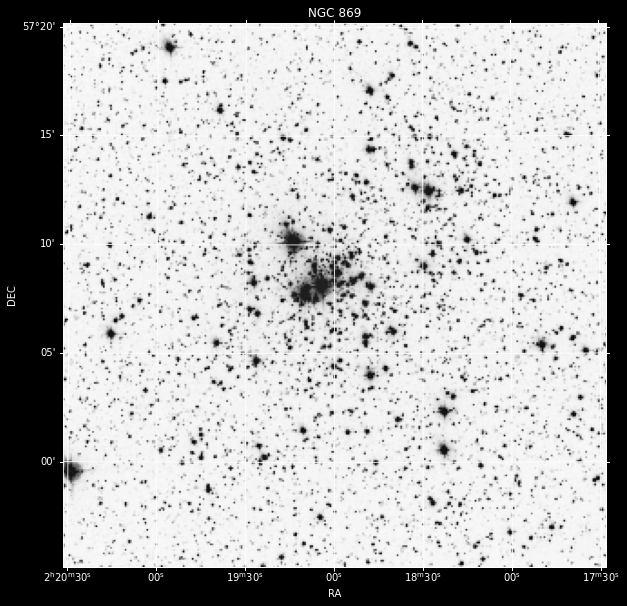

In [47]:
ax, hdu = plot_finder_image(ngc869, survey='DSS', fov_radius=25*u.arcmin)

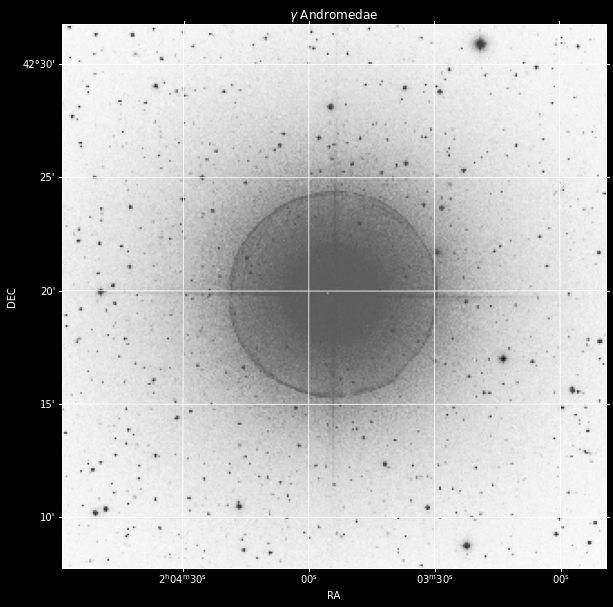

In [48]:
ax, hdu = plot_finder_image(gamand, survey='DSS', fov_radius=24*u.arcmin)

<PolarAxesSubplot:>

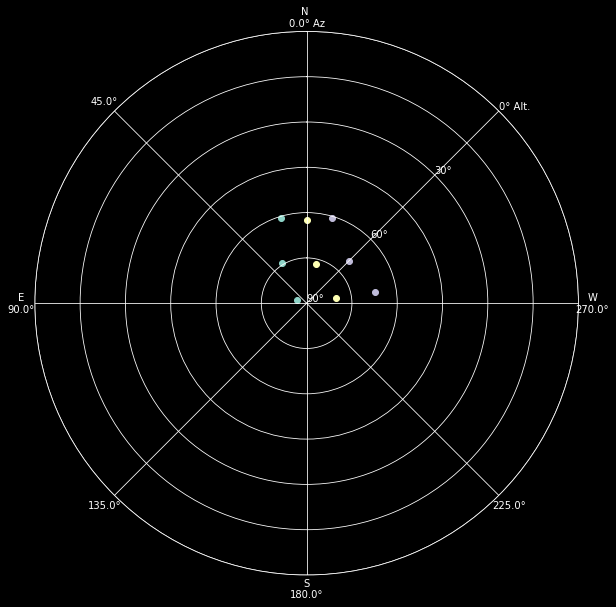

In [49]:
targets = [m33, ngc869, gamand]
plot_sky(target=targets, observer=CTO, time=sunset)
plot_sky(target=targets, observer=CTO, time=onehour_after_sunset)
plot_sky(target=targets, observer=CTO, time=twohours_after_sunset)

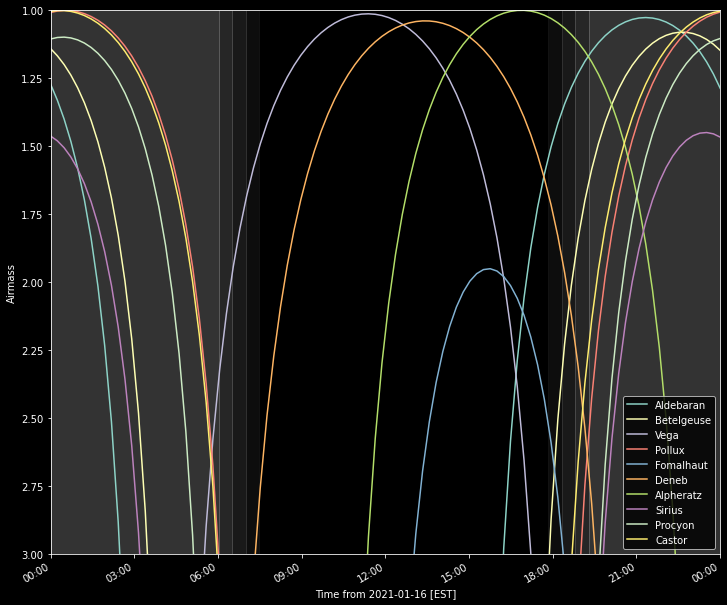

In [50]:
targets = [FixedTarget(coordinates.SkyCoord.from_name(name), name=name)
           for name in ('Aldebaran', 'Betelgeuse', 'Vega', 'Pollux', 'Fomalhaut', 'Deneb', 'Alpheratz',
                        'Sirius', 'Procyon', 'Castor')]

plot_airmass(targets,
             observer=CTO,
             time=Time('2021-01-16T17:00:00').to_datetime(timezone=CTO.timezone),
             use_local_tz=True,
             brightness_shading=True)

plt.legend(loc='best')
plt.show() 

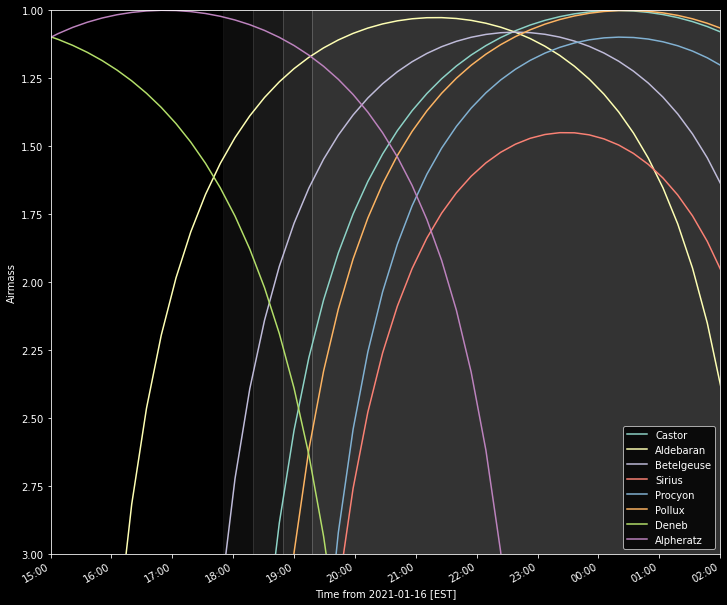

In [51]:
targets = [FixedTarget(coordinates.SkyCoord.from_name(name), name=name)
           for name in ('Castor', 'Aldebaran', 'Betelgeuse', 'Sirius', 'Procyon', 'Pollux', 'Deneb', 'Alpheratz')]

plot_airmass(targets,
             observer=CTO,
             time=Time('2021-01-16T20:00:00').to_datetime(timezone=CTO.timezone),
             use_local_tz=True,
             brightness_shading=True)


pl.gca().set_xlim(Time("2021-01-16T15:00:00").datetime,
                  Time("2021-01-17T02:00:00").datetime)
plt.legend(loc='best')
plt.show() 

# Exercise 2

We have been planning observations as ground-based observers, since that's what we are!

What about space-based observations?

If you're 

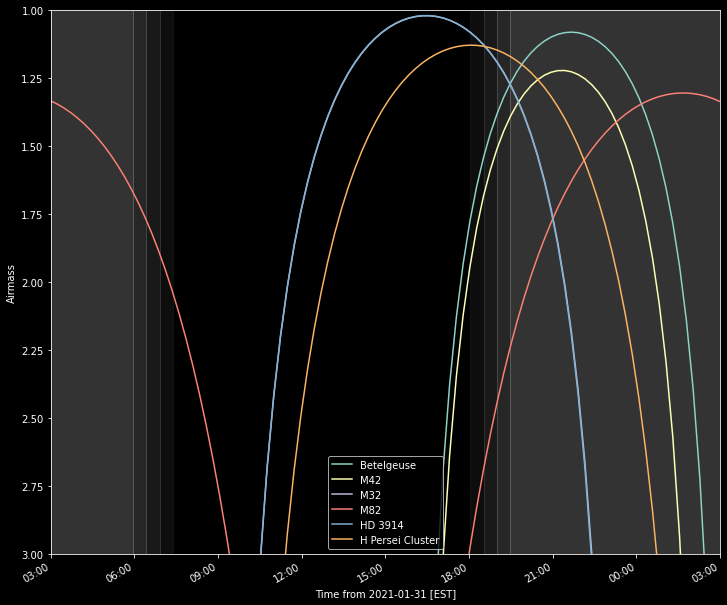

In [57]:
targets = [FixedTarget(coordinates.SkyCoord.from_name(name), name=name)
           for name in ('Betelgeuse', 'M42', 'M32', 'M82', 'HD 3914', 'H Persei Cluster')]

plot_airmass(targets,
             observer=CTO,
             time=Time('2021-01-31T20:00:00').to_datetime(timezone=CTO.timezone),
             use_local_tz=True,
             brightness_shading=True)


#pl.gca().set_xlim(Time("2021-01-31T15:00:00").datetime,
#                  Time("2021-01-31T02:00:00").datetime)
plt.legend(loc='best')
plt.show() 